# Image recognition using transfer learning
---
## InceptionV3

![](https://miro.medium.com/max/2000/0*te3xksOrVytM-B17)

A link to the paper can be found here: https://arxiv.org/pdf/1512.00567.pdf

#### Read in data from tensorflow datasets

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

# load Caltech Birds dataset from 2011
(train_ds, val_ds), ds_info = tfds.load('caltech_birds2011',
    split=['train','test'],
    shuffle_files=True,as_supervised=True,with_info=True)

print("Dataset info:\n", ds_info.description)

Dataset info:
 Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.


#### Data preprocessing
- normalize each image (256-bit color to float in [0,1])
- pad and rescale (shrink/enlarge dimensiona to 300px, adding white space when nesessary)
- batch images (number of images to be held in memory for each epoch )
- prefetch (during training step s, allow the data for training step s+1 to be loaded to optimize runtime )

In [2]:
# Set batch size and image dimensions allowed by your memory resources
batch_size = 128
image_height = 300
image_width = 300

def format_dataset(data):
    norm = lambda image,label:(tf.cast(image, tf.float32) / 255., label)
    pad = lambda image,label:(tf.image.resize_with_pad(image,image_height,image_width), label)
    data = data.map(norm, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.map(pad, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

# Prepare validation data
train_ds, val_ds = tuple(map(format_dataset,[train_ds,val_ds]))

#### Load in model

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


pretrained_model = InceptionV3(input_shape=(image_height,image_width,3),
                               include_top=False,
                               weights='imagenet')

# Iterate through layers and make untrainable
for layer in pretrained_model.layers:
    layer.trainable = False

# Flatten the output, and add fully connected layer with a node for each class
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='tanh')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(200, activation='softmax')(x)

# Adjust learning rate while training with LearningRateScheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**((100-epoch) / 20))
optimizer = tf.keras.optimizers.Adam()


# Use our model as the input layer
model = tf.keras.Model(pretrained_model.input, x)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

"""Uncomment the last line to see the model summary. Warning: it is very long""" 
#model.summary()

# Model Training

We being by importing the pretrained model and setting the input shape to match the images we seek to classify

In [0]:
# Fit the model
history = model.fit(
    train_ds,
    epochs=100,
    shuffle=False,
    batch_size=batch_size,
    validation_data=val_ds,
    callbacks=[lr_scheduler]
)

Epoch 1/100
47/47 [==============================] - 27s 576ms/step - loss: 5.3919 - accuracy: 0.0165 - val_loss: 5.0603 - val_accuracy: 0.0343 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 26s 553ms/step - loss: 4.9780 - accuracy: 0.0382 - val_loss: 4.7690 - val_accuracy: 0.0654 - lr: 8.9125e-04
Epoch 3/100
47/47 [==============================] - 26s 549ms/step - loss: 4.7160 - accuracy: 0.0591 - val_loss: 4.5656 - val_accuracy: 0.0768 - lr: 7.9433e-04
Epoch 4/100
47/47 [==============================] - 25s 530ms/step - loss: 4.4635 - accuracy: 0.0841 - val_loss: 4.3461 - val_accuracy: 0.0977 - lr: 7.0795e-04
Epoch 5/100
47/47 [==============================] - 26s 551ms/step - loss: 4.2438 - accuracy: 0.1118 - val_loss: 4.1692 - val_accuracy: 0.1229 - lr: 6.3096e-04
Epoch 6/100
47/47 [==============================] - 26s 555ms/step - loss: 4.0170 - accuracy: 0.1468 - val_loss: 3.9675 - val_accuracy: 0.1588 - lr: 5.6234e-04
Epoch 7/100
47/47 [===================

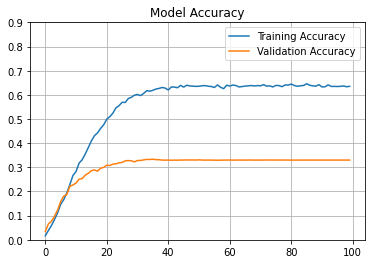

In [0]:
acc = history.history['accuracy']
val = history.history['val_accuracy']

plt.title('Model Accuracy')
plt.plot(range(100), acc, label='Training Accuracy')
plt.plot(range(100), val, label='Validation Accuracy')
plt.yticks([i / 10.0 for i in range(10)])
plt.ylim([0,.9])
plt.grid()
plt.legend()
plt.show()